https://stepik.org/lesson/1576206/step/10

0.27453795075416565


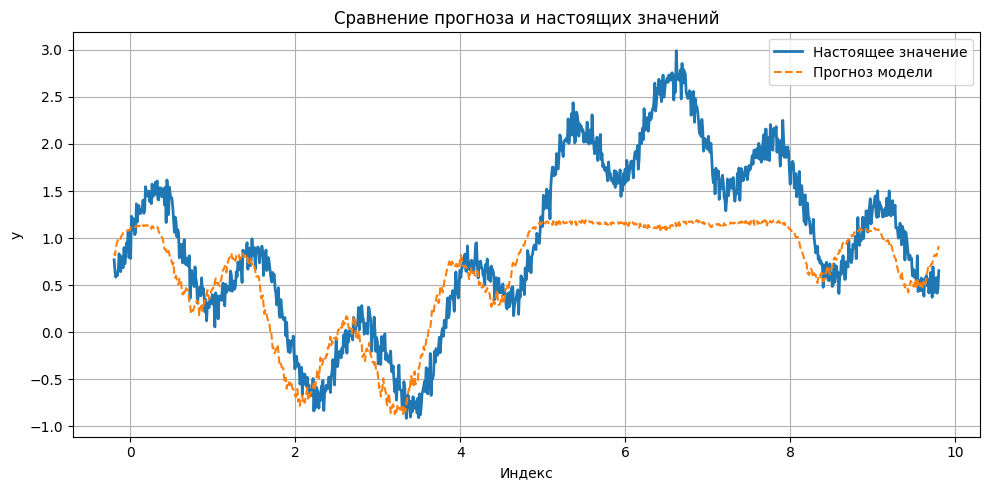

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

class LSTMToLinear(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # От LSTM x приходит в таком виде:
        lstm_out, (h_t, c_t) = x
        return h_t.squeeze(0)  # скрытое состояние (hidden state) - по заданию
        # return c_t.squeeze(0)  # состояние ячейки (cell state) - лучше результат



model = nn.Sequential(
    nn.LSTM(
        input_size=1,   # <- было 20, теперь 1
        hidden_size=10, # соответствует Linear(10, 1)
        batch_first=True
    ),
    LSTMToLinear(),
    nn.Linear(10, 1)
)

x = torch.linspace(-10, 10, 2000)
y = torch.cos(x) + 0.5 * torch.sin(5*x) + 0.1 * torch.randn_like(x) + 0.2 * x
y_graph = y.clone() # для графика

total = len(x)      # общее количество отсчетов
train_size = 1000   # размер обучающей выборки
seq_length = 20     # число предыдущих отсчетов, по которым строится прогноз следующего значения

y.unsqueeze_(1)
train_data_y = torch.cat([y[i:i+seq_length] for i in range(train_size-seq_length)], dim=1)
train_targets = torch.tensor([y[i+seq_length].item() for i in range(train_size-seq_length)])

test_data_y = torch.cat([y[i:i+seq_length] for i in range(train_size-seq_length, total-seq_length)], dim=1)
test_targets = torch.tensor([y[i+seq_length].item() for i in range(train_size-seq_length, total-seq_length)])

d_train = data.TensorDataset(train_data_y.permute(1, 0), train_targets)
d_test = data.TensorDataset(test_data_y.permute(1, 0), test_targets)

train_data = data.DataLoader(d_train, batch_size=8, shuffle=True)
test_data = data.DataLoader(d_test, batch_size=len(d_test), shuffle=False)

optimizer = optim.RMSprop(params=model.parameters(), lr=0.01) # оптимизатор RMSprop с шагом обучения 0.01
loss_func = nn.MSELoss()    # функция потерь - средний квадрат ошибок

epochs = 5    # число эпох
model.train() # переведите модель в режим обучения

for _e in range(epochs):
    for x_train, y_train in train_data:
        # вычислите прогноз модели для x_train
        predict = model(x_train.unsqueeze(-1)).squeeze()
        loss = loss_func(predict, y_train)

        optimizer.zero_grad() # обнуляем градиенты
        loss.backward()       # вычисляем градиенты
        optimizer.step()      # обновляем веса модели

model.eval()
# с использованием менеджера torch.no_grad вычислите прогнозы для выборки d
# результат сохраните в тензоре predict
data, target = next(iter(test_data))
with torch.no_grad():
    predict = model(data.unsqueeze(-1)).squeeze()

# вычислите потери с помощью loss_func для predict и t; значение Q сохраните в виде вещественного числа
Q = loss_func(predict, target).item()

# # График
# import matplotlib.pyplot as plt

# x_test = x[train_size - seq_length:total - seq_length]

# plt.plot(x_test.detach().numpy(), y_graph[train_size - seq_length:total - seq_length].detach().numpy(), label="Настоящее значение", linewidth=2)
# plt.plot(x_test.detach().numpy(), predict.detach().numpy(), label="Прогноз модели", linestyle='--')
# plt.title("Сравнение прогноза и настоящих значений")
# plt.xlabel("Индекс")
# plt.ylabel("y")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()